<h1><b>Heart Disease Datasset </b></h1>

---

# Install required packages

In [41]:
%pip install matplotlib seaborn scikit-learn ucimlrepo graphviz

Note: you may need to restart the kernel to use updated packages.


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import graphviz

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import display, Image

# **1. Fetch the dataset**

In [43]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)

# print shape of the data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

## **1.1 Data Preprocessing**

**There are some features that have missing values, let's check**

In [45]:
# Count the missing values in each column
print(X.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


In [46]:
# Count the number of rows that have missing values
print(X.isnull().any(axis=1).sum())

6


Because there is only 6 missing values, which lay on 6 different rows over 303 rows, we can drop those rows without losing too much information.

In [47]:
X = X.dropna(axis=0, how='any')
y = y.loc[X.index]

# Check the shape after dropping missing values
print(f"Shape of X after dropping missing values: {X.shape}")
print(f"Shape of y after dropping missing values: {y.shape}")

Shape of X after dropping missing values: (297, 13)
Shape of y after dropping missing values: (297, 1)


Show target variable distribution

In [48]:
print(y.value_counts())

num
0      160
1       54
2       35
3       35
4       13
Name: count, dtype: int64


## **1.2 Encode target to binary set**

Convert the target variable to 0 and 1, where 0 means no heart disease and 1 means heart disease.

Rules:
- If target is 0, then it means no heart disease (Labeled as 0).
- If target is greater than 0, then it means heart disease (Labeled as 1).

In [49]:
y = (y != 0).astype(int)

# print the distribution of the target variable
print(y.value_counts())

num
0      160
1      137
Name: count, dtype: int64


# **2. Spit the dataset into train and test sets**

## **2.1 Split the dataset**

In [50]:
# Define train/test proportions
train_sizes = [0.4, 0.6, 0.8, 0.9]

# Create all necessary subdirectories
base_dirs = ["feature_train", "feature_test", "label_train", "label_test"]
ratios = ["40_60", "60_40", "80_20", "90_10"]

for base_dir in base_dirs:
    for ratio in ratios:
        os.makedirs(os.path.join(base_dir, ratio), exist_ok=True)

for i, train_size in enumerate(train_sizes):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=train_size,
        stratify=y,
        shuffle=True,
        random_state=21
    )

    ratio_str = ratios[i]

    X_train_path = f"feature_train/{ratio_str}/X_train.csv"
    X_test_path = f"feature_test/{ratio_str}/X_test.csv"
    y_train_path = f"label_train/{ratio_str}/y_train.csv"
    y_test_path = f"label_test/{ratio_str}/y_test.csv"

    # Save to files
    X_train.to_csv(X_train_path, index=False)
    X_test.to_csv(X_test_path, index=False)
    y_train.to_csv(y_train_path, index=False)
    y_test.to_csv(y_test_path, index=False)


## **2.2 Class distribution**

In [51]:
def add_count_labels(ax, fontsize=8):
    for patch in ax.patches:
        height = patch.get_height()
        ax.annotate(f'{int(height)}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=fontsize)


def show_class_distribution(target_data, title):
    """Plot class distribution for a original dataset."""
    plt.figure(figsize=(10, 6))

    values = target_data.iloc[:, 0]

    sns.countplot(x=values, legend=False)
    plt.title(title)
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')

    # Set custom labels
    plt.xticks(ticks=[0, 1], labels=['No Heart Disease', 'Heart Disease'])

    add_count_labels(plt.gca())
    plt.show()


def plot_single_dataset(ax, file_path, title, is_train=True):
    """Plot distribution for a single dataset."""
    df = pd.read_csv(file_path)
    values = df.iloc[:, 0]

    sns.countplot(x=values, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Disease', 'Disease'])

    add_count_labels(ax, fontsize=8)


def compare_single_ratio(ratio):
    """Plot comparasion of class distribution."""
    _, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Train distribution
    train_path = os.path.join("label_train", ratio, "y_train.csv")
    plot_single_dataset(axes[0], train_path, f'Train {ratio.replace("_", "/")}')

    # Test distribution
    test_path = os.path.join("label_test", ratio, "y_test.csv")
    plot_single_dataset(axes[1], test_path, f'Test {ratio.replace("_", "/")}')

    plt.tight_layout()
    plt.suptitle(f'Train vs Test Comparison - Ratio {ratio.replace("_", ":")}')
    plt.show()

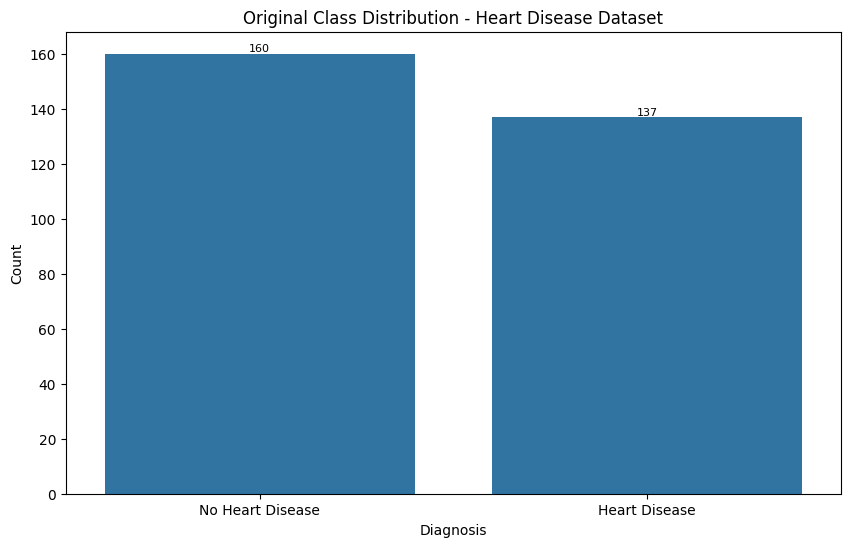

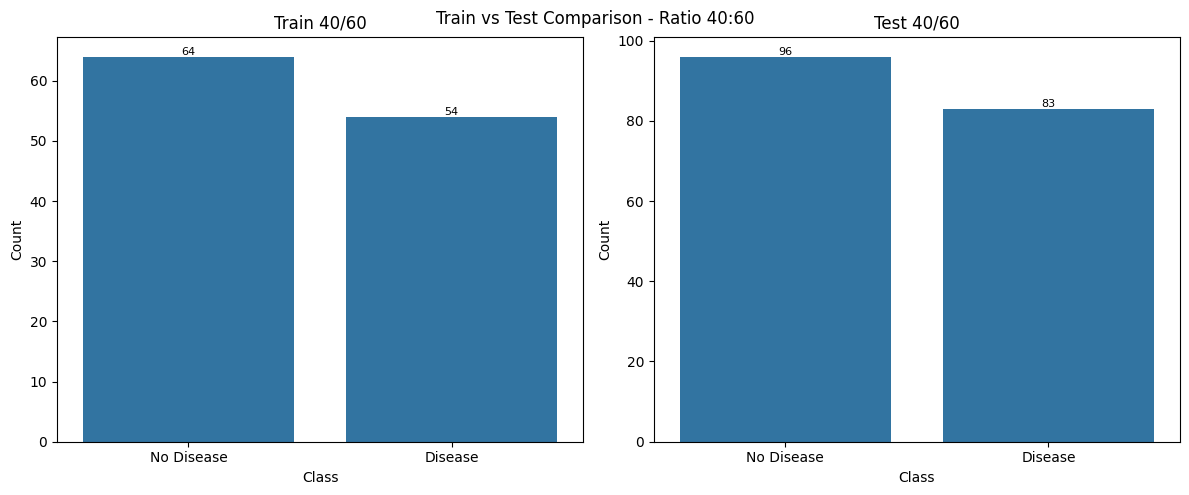

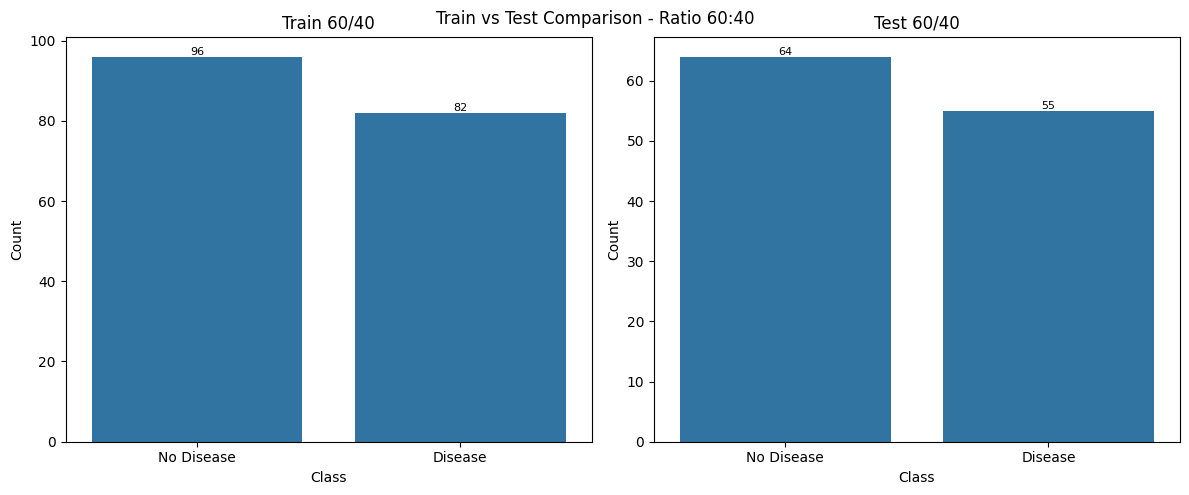

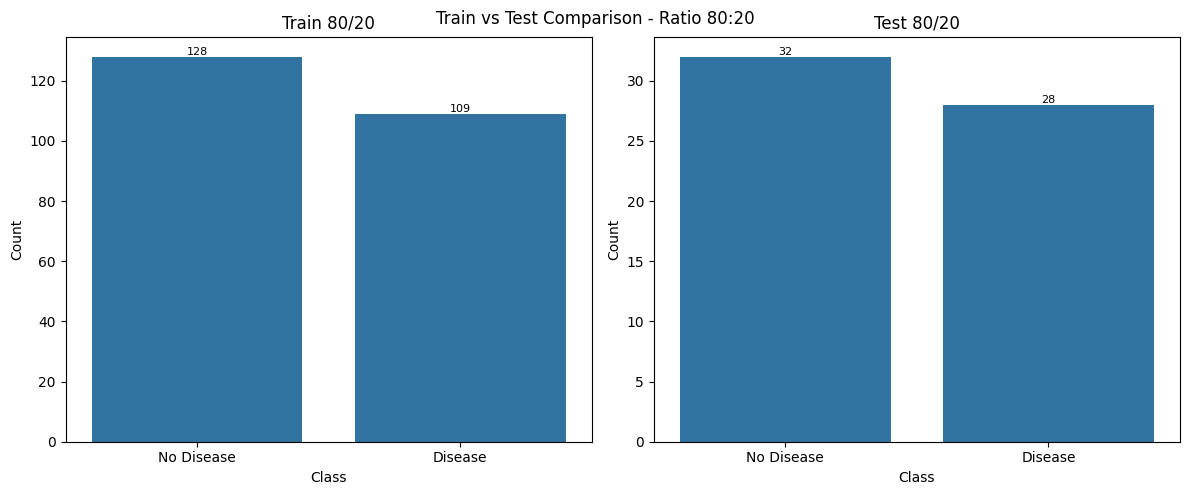

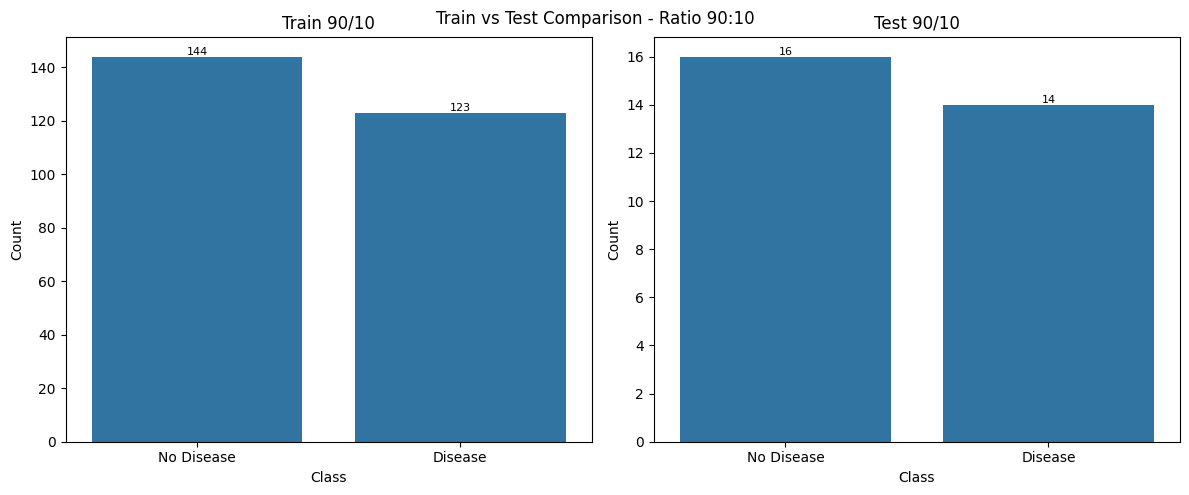

In [52]:
show_class_distribution(y, 'Original Class Distribution - Heart Disease Dataset')

for ratio in ratios:
    compare_single_ratio(ratio)

# **3. Descision Tree Classifier**

## **3.1 Construct a Decision Tree Classifier**

In [53]:
def fit_and_visualize_decision_tree(X_train, y_train, ratio, max_depth=None, is_show=True, base_dir="images"):

    clf = DecisionTreeClassifier(
        criterion='entropy', max_depth=max_depth, random_state=42)

    # Train classifier
    clf.fit(X_train, y_train)

    # Visualize via Graphviz
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=X_train.columns,
        class_names=['No Heart Disease', 'Heart Disease'],
        filled=True, rounded=True, special_characters=True
    )

    # Create graph object and save image
    graph = graphviz.Source(dot_data)

    # Generate PNG content and save to file
    png_content = graph.pipe(format='png')

    # Save the PNG image
    filename = f"{base_dir}/decision_tree_{ratio}-{max_depth}.png"
    with open(filename, 'wb') as f:
        f.write(png_content)

    if is_show:
        # Display the image
        display(Image(png_content))

    return clf

## **3.2. Evaluating the decision tree classifiers (No limit for max depth)**

In [ ]:
def fit_and_evaluate_decision_tree(clf, X_test, y_test, ratio, max_depth=None):
    """Fit the classifier, make predictions, and evaluate performance."""
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    

    # Classification report and confusion matrix
    report = classification_report(y_test, y_pred, digits=3)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Decision Tree Classifier Report (Max_depth: {max_depth})")
    print("Classification Report:\n", report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf.classes_,
                yticklabels=clf.classes_)
    plt.title(
        f'Confusion Matrix (Train={round((1-ratio)*100, 0)}%, Test={round((ratio)*100, 0)}%, Depth={max_depth})')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.tight_layout()
    plt.show()
    print('======================================================================\n')
    
    return accuracy

Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

           0      0.684     0.698     0.691        96
           1      0.642     0.627     0.634        83

    accuracy                          0.665       179
   macro avg      0.663     0.662     0.662       179
weighted avg      0.664     0.665     0.664       179



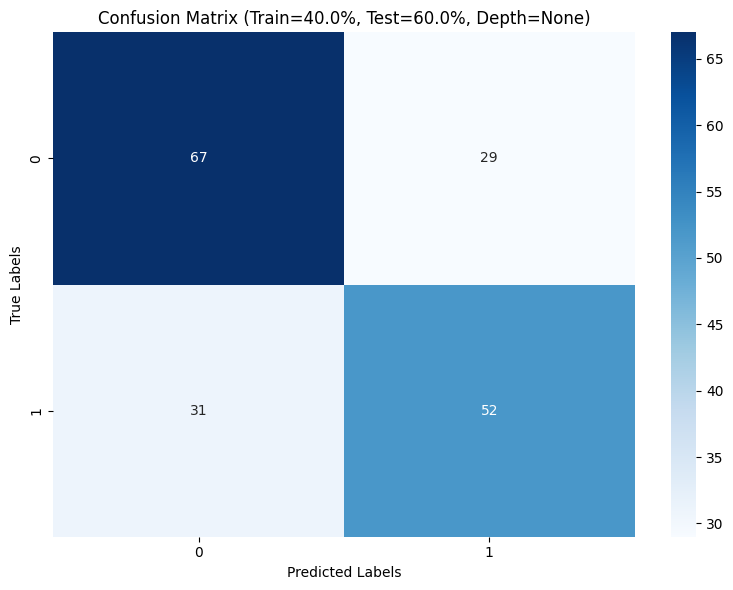


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

           0      0.677     0.656     0.667        64
           1      0.614     0.636     0.625        55

    accuracy                          0.647       119
   macro avg      0.646     0.646     0.646       119
weighted avg      0.648     0.647     0.647       119



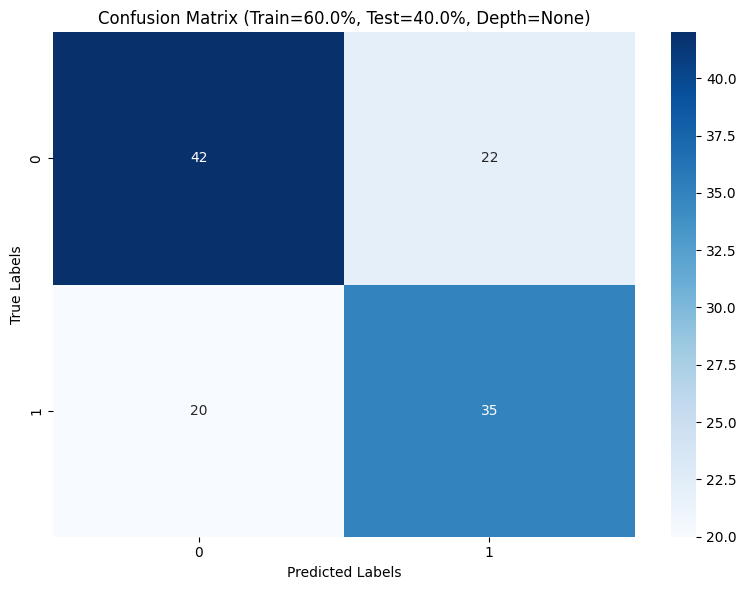


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

           0      0.694     0.781     0.735        32
           1      0.708     0.607     0.654        28

    accuracy                          0.700        60
   macro avg      0.701     0.694     0.695        60
weighted avg      0.701     0.700     0.697        60



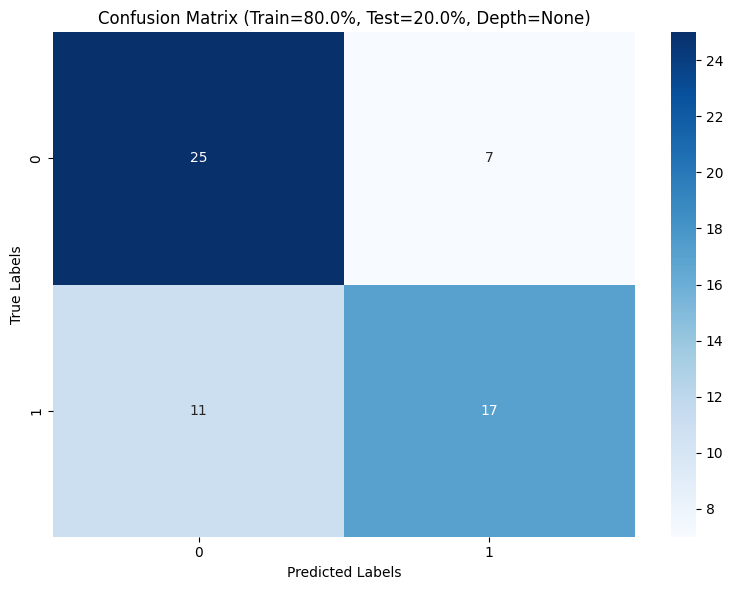


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

           0      0.667     0.875     0.757        16
           1      0.778     0.500     0.609        14

    accuracy                          0.700        30
   macro avg      0.722     0.688     0.683        30
weighted avg      0.719     0.700     0.688        30



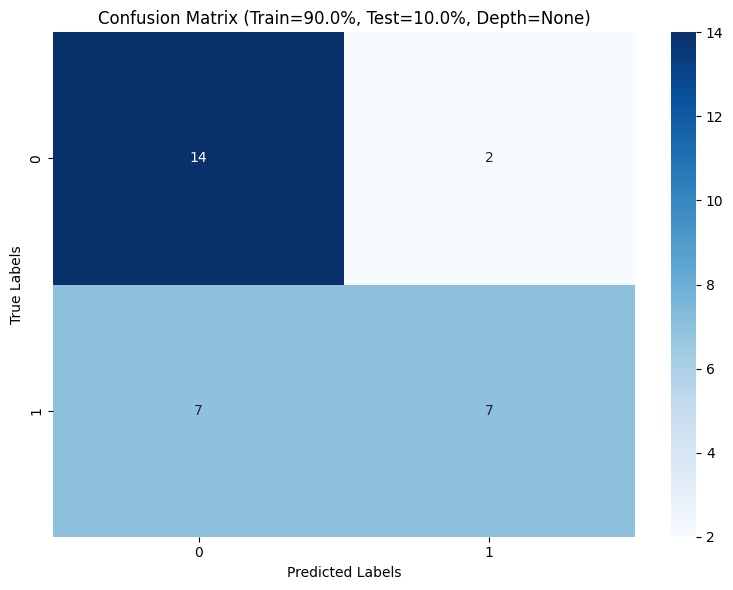

In [55]:
for ratio in ratios:
    feature_test_path = os.path.join("feature_test", ratio, "X_test.csv")
    label_test_path = os.path.join("label_test", ratio, "y_test.csv")
    
    X__train = pd.read_csv(os.path.join("feature_train", ratio, "X_train.csv"))
    y__train = pd.read_csv(os.path.join("label_train", ratio, "y_train.csv"))

    clf = fit_and_visualize_decision_tree(
        X__train,
        y__train,
        ratio=ratio,
        max_depth=None,
        is_show=False
    )

    fit_and_evaluate_decision_tree(
        clf,
        pd.read_csv(feature_test_path),
        pd.read_csv(label_test_path),
        ratio=int(ratio.split('_')[1])*0.01,
        max_depth=None,
    )

## **3.3. Evaluating the decision tree classifiers with different max depths (focus on 80/20 train-test split)**

In [56]:
# Initialize a list to store accuracies for each ratio
accuracies = []

Decision Tree Classifier Report (Max_depth: 2)
Classification Report:
               precision    recall  f1-score   support

           0      0.625     0.938     0.750        32
           1      0.833     0.357     0.500        28

    accuracy                          0.667        60
   macro avg      0.729     0.647     0.625        60
weighted avg      0.722     0.667     0.633        60



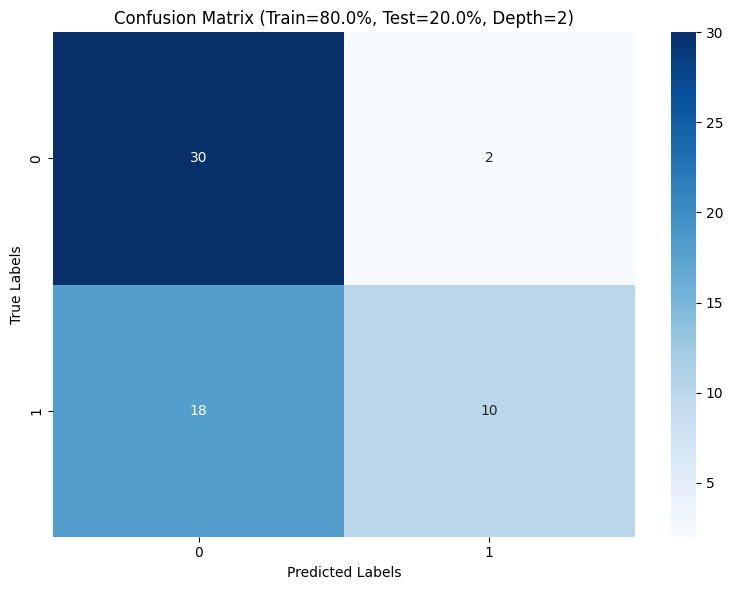


Decision Tree Classifier Report (Max_depth: 3)
Classification Report:
               precision    recall  f1-score   support

           0      0.800     0.750     0.774        32
           1      0.733     0.786     0.759        28

    accuracy                          0.767        60
   macro avg      0.767     0.768     0.766        60
weighted avg      0.769     0.767     0.767        60



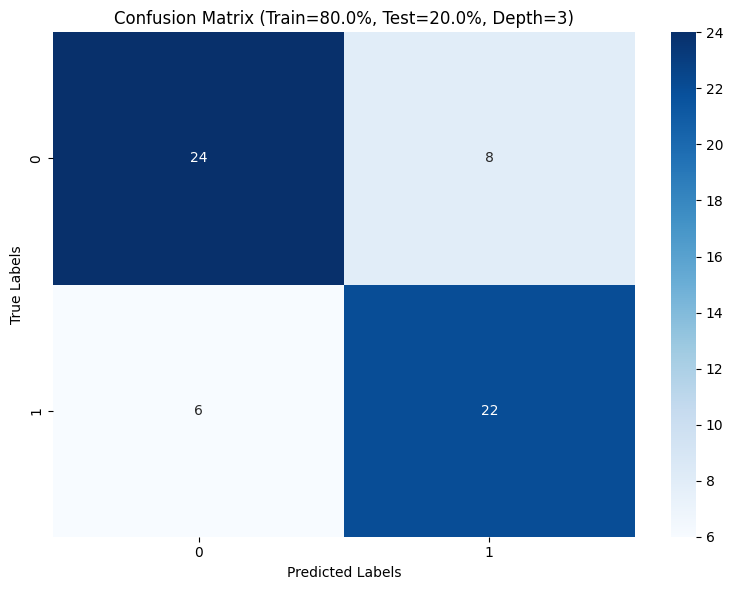


Decision Tree Classifier Report (Max_depth: 4)
Classification Report:
               precision    recall  f1-score   support

           0      0.722     0.812     0.765        32
           1      0.750     0.643     0.692        28

    accuracy                          0.733        60
   macro avg      0.736     0.728     0.729        60
weighted avg      0.735     0.733     0.731        60



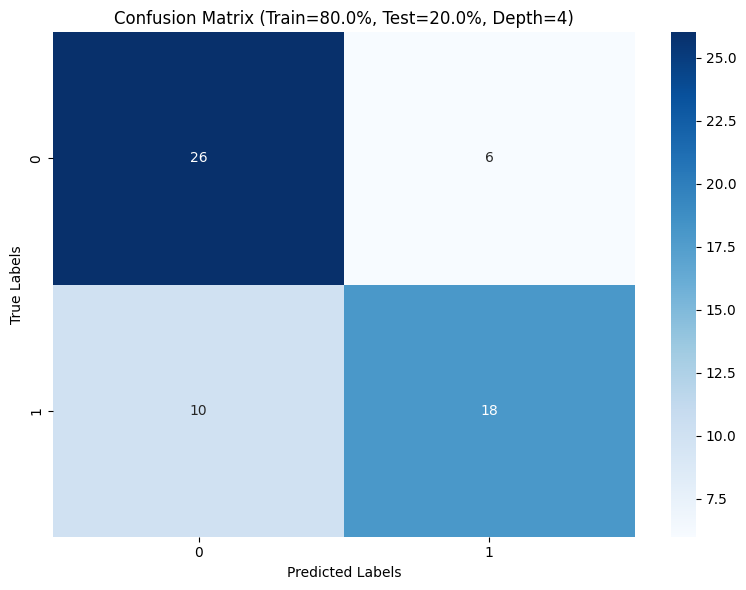


Decision Tree Classifier Report (Max_depth: 5)
Classification Report:
               precision    recall  f1-score   support

           0      0.686     0.750     0.716        32
           1      0.680     0.607     0.642        28

    accuracy                          0.683        60
   macro avg      0.683     0.679     0.679        60
weighted avg      0.683     0.683     0.681        60



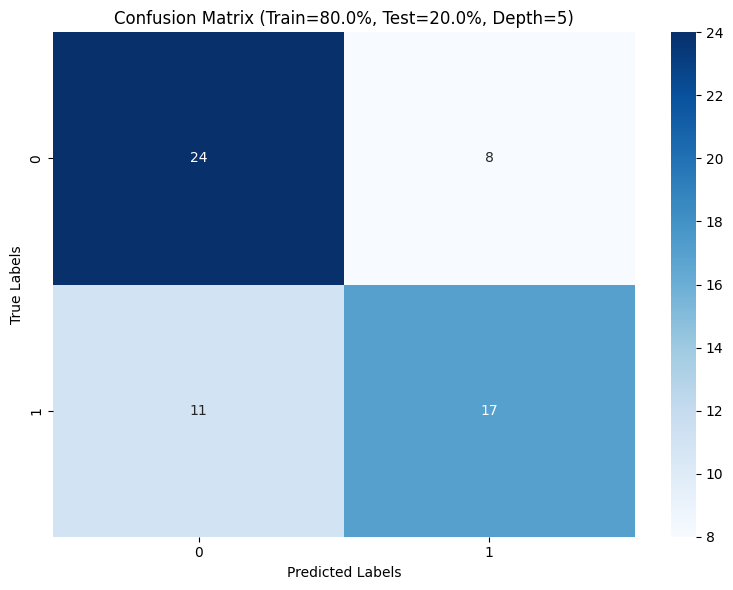


Decision Tree Classifier Report (Max_depth: 6)
Classification Report:
               precision    recall  f1-score   support

           0      0.694     0.781     0.735        32
           1      0.708     0.607     0.654        28

    accuracy                          0.700        60
   macro avg      0.701     0.694     0.695        60
weighted avg      0.701     0.700     0.697        60



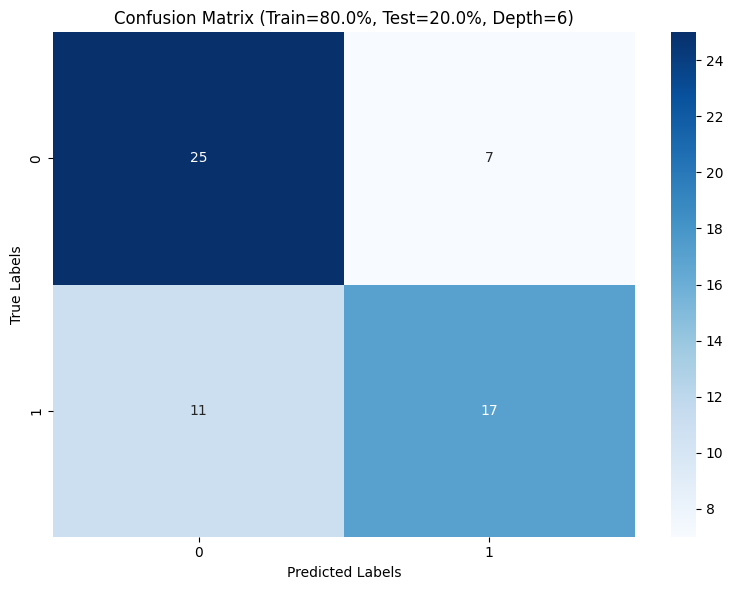


Decision Tree Classifier Report (Max_depth: 7)
Classification Report:
               precision    recall  f1-score   support

           0      0.694     0.781     0.735        32
           1      0.708     0.607     0.654        28

    accuracy                          0.700        60
   macro avg      0.701     0.694     0.695        60
weighted avg      0.701     0.700     0.697        60



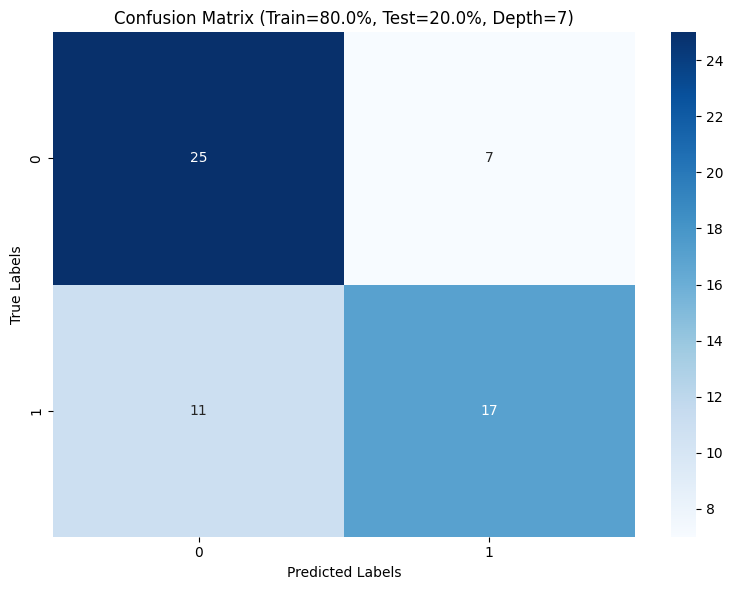


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

           0      0.694     0.781     0.735        32
           1      0.708     0.607     0.654        28

    accuracy                          0.700        60
   macro avg      0.701     0.694     0.695        60
weighted avg      0.701     0.700     0.697        60



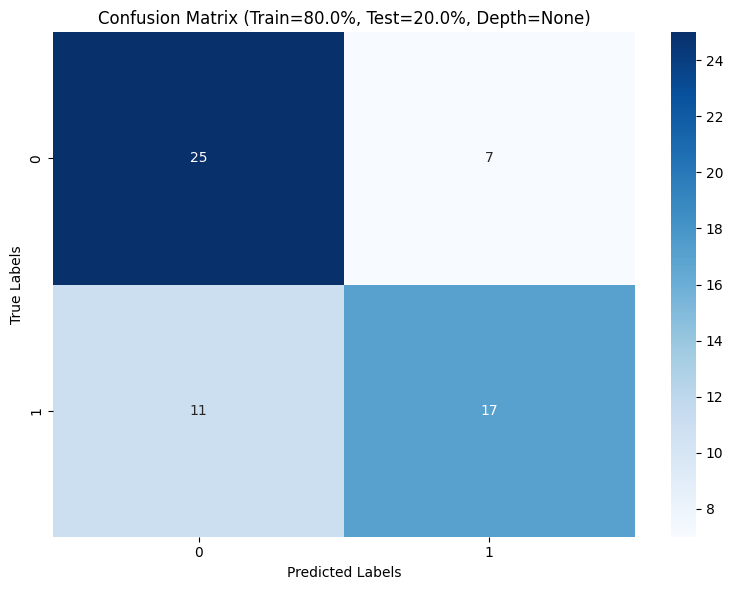

In [57]:
ratio = "80_20"
max_depths = [2, 3, 4, 5, 6, 7, None]

feature_test_path = os.path.join("feature_test", ratio, "X_test.csv")
label_test_path = os.path.join("label_test", ratio, "y_test.csv")

X__train = pd.read_csv(os.path.join("feature_train", ratio, "X_train.csv"))
y__train = pd.read_csv(os.path.join("label_train", ratio, "y_train.csv"))

for max_depth in max_depths:
    clf = fit_and_visualize_decision_tree(
        X__train,
        y__train,
        ratio=ratio,
        max_depth=max_depth,
        is_show=False,
        base_dir="images/80_20_vary_depth"
    )

    accuracy = fit_and_evaluate_decision_tree(
        clf,
        pd.read_csv(feature_test_path),
        pd.read_csv(label_test_path),
        ratio=int(ratio.split('_')[1])*0.01,
        max_depth=max_depth,
    )

    accuracies.append(accuracy)

In [58]:
for max_depth, accuracy in zip(max_depths, accuracies):
    print(f"Max Depth: {max_depth}, Accuracy: {accuracy}")

Max Depth: 2, Accuracy: 0.6666666666666666
Max Depth: 3, Accuracy: 0.7666666666666667
Max Depth: 4, Accuracy: 0.7333333333333333
Max Depth: 5, Accuracy: 0.6833333333333333
Max Depth: 6, Accuracy: 0.7
Max Depth: 7, Accuracy: 0.7
Max Depth: None, Accuracy: 0.7


Thus,

|max_depth|None|2|3|4|5|6|7|
|---------|----|-|-|-|-|-|-|
|**accuracy**|0.7000|0.6667|0.7667|0.7333|0.6833|0.7000|0.7000|

**Visualize the accuracy of the decision tree classifier with different max depth values.**

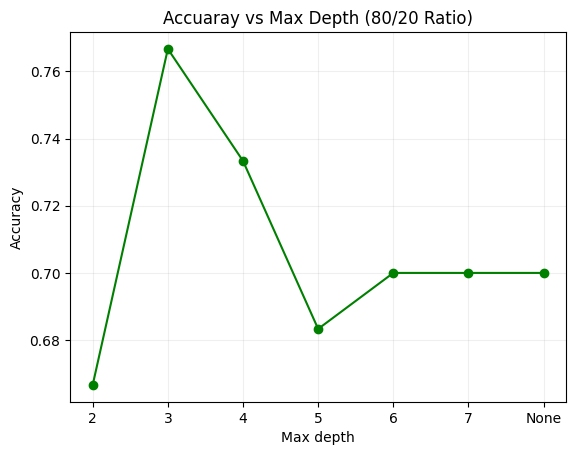

In [60]:
plt.plot([str(x) for x in max_depths],
         accuracies, color='green', marker='o')
plt.title('Accuaray vs Max Depth (80/20 Ratio)')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.grid(alpha=0.2)
plt.show()

Due to the fact that the accuracy is not significantly different for different max depths, we can choose any of them. However, we will choose max_depth=3 as it has the highest accuracy.